# Data Pre-Processing

In this phase, we will clean up our data sets and perform some data pre-processing techniques before we proceed with the data analysis. This is to ensure that the quality input that we feed into our model which will result in a better classifier.

In [1]:
# import libraries
import pandas as pd
import nltk as nltk
import itertools
import string
import matplotlib.pyplot as plt
%matplotlib inline 

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tag import pos_tag_sents
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk import bigrams
from nltk.classify import NaiveBayesClassifier
from nltk.probability import FreqDist, ConditionalFreqDist

# only need to download the following once
# nltk.download('punkt') # to use word_tokenize
# nltk.download('stopwords') # to use stopwords
# nltk.download('averaged_perceptron_tagger') # to use pos tagger
# nltk.download('wordnet') # to use wordnet pos tagger

In [2]:
# loading data sets from .csv files into pandas data frame
BG_df = pd.read_csv('..\\Dissertation_Code\\BG.csv', encoding='utf-8')

# naming our data set for future functionality
BG_df.name = 'BG_df'

The first step of pre-processing is to create a new column which categorises the ratings into two sentiments, positive and negative. Ratings 1 and 2 will be categorised into negative sentiment, while ratings 4 and 5 will be categorsied into positive sentiment. Ratings 0 and 3 will be considered as neutral and therefore eliminated from our data sets. Before proceeding with the categorisation, we check how many percentages are the ratings 0 and 3 out of the whole data sets.

In [3]:
# first review of BG_df before pre-processing
BG_df['reviews'].loc[0]

'            Hive engineer failed to show twice after I had taken two days off work to get hive installed. British Gas employees wouldn’t give a monkeys,I suppose it’s the shareholders that are suffering . Because of the engineer not showing up twice I decided to cancel my boiler care and appliance cover with them as well as cancel this hive contract so a sum of about £110 a month lost. I will give my money to someone who wants it. Honestly you guys were great a few years back, but now you are mediocre at best. What the hell has happened to you.\r\n        '

In [4]:
# checking the frequency of each ratings for BG_df
BG_df['rating'].value_counts()

1    1463
5    1416
4     409
2     231
3     197
Name: rating, dtype: int64

The percentage of entries with the values of 0 and 3 for BG_df is 5.30%. Removing these entries from our data sets, we are left with 3,519 reviews, acceptable numbers for further analysis.

In [5]:
# function to remove neutral entries and categorise into sentiments
def categorise(df):
    df.drop(df[df['rating'] == 0].index, inplace=True)
    df.drop(df[df['rating'] == 3].index, inplace=True)
    
    df['sentiment'] = None # initialising column
    df.loc[df['rating'] >= 4.0, 'sentiment'] = 'Positive'
    df.loc[df['rating'] <= 2.0, 'sentiment'] = 'Negative'

In [6]:
# using the categorise function and checking the frequency again
categorise(BG_df)
BG_df['rating'].value_counts()

1    1463
5    1416
4     409
2     231
Name: rating, dtype: int64

In [7]:
# checking the frequency of positive and negative sentiment
BG_df['sentiment'].value_counts()

Positive    1825
Negative    1694
Name: sentiment, dtype: int64

In [8]:
# checking the first 5 rows after categorising
BG_df.head()

,rating,reviews,date,sentiment
0,1,Hive engineer failed to show twice...,2018-07-09T17:56:48.000+00:00,Negative
1,1,I moved from SSE to British Gas be...,2018-07-09T09:38:39.000+00:00,Negative
2,1,There engineers were rude and sur...,2018-07-09T07:17:10.000+00:00,Negative
3,1,Firstly the App never works and th...,2018-07-06T15:09:05.000+00:00,Negative
4,1,Conned me left right and centre. B...,2018-07-05T15:02:28.000+00:00,Negative


Note that the dates are in different versions. Let us standardise this first before proceeding with the other cleaning.

In [9]:
# function to standardise date
def standardise_date(df):
    df['date'] = [x[0:10] for x in df['date']]
    df['date'] = pd.to_datetime(df['date']).apply(lambda x:x.strftime('%d/%m/%Y'))

In [10]:
# standardising date and checking
standardise_date(BG_df)
BG_df.head()

,rating,reviews,date,sentiment
0,1,Hive engineer failed to show twice...,09/07/2018,Negative
1,1,I moved from SSE to British Gas be...,09/07/2018,Negative
2,1,There engineers were rude and sur...,09/07/2018,Negative
3,1,Firstly the App never works and th...,06/07/2018,Negative
4,1,Conned me left right and centre. B...,05/07/2018,Negative


The dates seem fine now. Next, let us check if there's any missing value within our data sets. Note that Pandas classify missing value as NaN. If there are any, we would need to either omit the row or perform some imputation.

In [11]:
# checking NaN values for BG_df
BG_df.isna().any()

rating       False
reviews      False
date         False
sentiment    False
dtype: bool

There are no missing values, thus we continue our pre-processing with the first process of text pre-processing, tokenisation, which is essentially breaking down the documents into smaller pieces.

In [12]:
# testing tokenization
text_test = "I liked British Gas's price."
token_test = word_tokenize(text_test)
token_test

['I', 'liked', 'British', 'Gas', "'s", 'price', '.']

In [13]:
# function to tokenise review texts
def tokenise(df):
    df['tokens'] = df['reviews'].str.lower().apply(word_tokenize)

In [14]:
# tokenise both data sets
tokenise(BG_df)
BG_df.head()

,rating,reviews,date,sentiment,tokens
0,1,Hive engineer failed to show twice...,09/07/2018,Negative,"[hive, engineer, failed, to, show, twice, afte..."
1,1,I moved from SSE to British Gas be...,09/07/2018,Negative,"[i, moved, from, sse, to, british, gas, becaus..."
2,1,There engineers were rude and sur...,09/07/2018,Negative,"[there, engineers, were, rude, and, surely.3, ..."
3,1,Firstly the App never works and th...,06/07/2018,Negative,"[firstly, the, app, never, works, and, the, pe..."
4,1,Conned me left right and centre. B...,05/07/2018,Negative,"[conned, me, left, right, and, centre, ., been..."


After tokenisation, we then proceed with stop words and punctuation removals. Stop words are common words that often do not add value in our classifier.

In [15]:
# list of stop words and punctuations to remove
sent_stops = ['not', 'again', 'against', "aren't", "couldn't", "didn't", "doesn't", "don't", "hadn't", "hasn't", "haven't", "isn't",
              "mightn't", "mustn't", "needn't", 'not', 'off', 'on', 'over', 'same', "shan't", "should've", "shouldn't", 'under', 
              "wasn't", "weren't", "why", "won't", "wouldn't"]
stops = set(stopwords.words('english')) - set(sent_stops) | set(string.punctuation + '’')
#print(stops)

{'}', 'himself', 'myself', 'y', 'the', 'we', 'in', '#', 'until', 'below', 'those', 'these', 'shan', '\\', 'few', 'than', 'don', ':', 'my', 'between', 'won', 'they', "you've", '>', 'just', 'hasn', 'will', '"', 'both', 'their', '~', 'an', 'down', 'of', '`', 'with', 'o', 'its', 'itself', 'when', 'some', 'other', '_', 'are', 'she', 'have', '*', 've', 'a', 'each', 'he', 'after', 'to', 'where', 'mustn', 'wasn', 'weren', '%', 'through', 'hadn', '.', 'what', 'at', 'too', 'yours', 'then', 'further', 'am', 'did', "you'd", 'for', '(', 'that', 'theirs', 'has', "'", 'i', 'you', 'about', "you're", 'me', 'her', 'ma', "that'll", 'had', 'couldn', 'ourselves', 'and', '@', "it's", 'been', 'as', 'no', 'aren', ',', '/', 'themselves', 'while', 'how', 'all', 'haven', 'hers', '!', 'him', 'any', 'before', '+', '-', 'out', 'having', 'most', 'being', 'll', 'during', 'whom', 'isn', 'be', 'own', 'doesn', 'shouldn', 'herself', 'was', ']', '’', 'his', '{', 'this', 'mightn', 'doing', 'very', 'more', 'can', 'our', 's'

In [16]:
punctuations = list(string.punctuation)

# function to remove stop words and punctuations
def stops_removal(df):
    df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stops])
    df['tokens'] = df['tokens'].apply(lambda x: [i.strip("".join(punctuations)) for i in x if i not in punctuations]) # strip punctuation from tokens
    df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word]) # remove whitespace strings from token lists
    return df

Next, we proceed with the two processes of text normalisation, stemming and lemmatisation. Stemming has its advantage in terms of its speed and scalability while lemmatisation would provide a more accurate word normalisation and improve understandability. 

In [17]:
# function to stem words
def stemming(df):
    stemmer = SnowballStemmer('english') # English Snowball Stemmer
    df['tokens'] = df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])
    return df

# function to lemmatise words
def lemmatise(df):
    lemmatiser = WordNetLemmatizer()
    df['tokens'] = pos_tag_sents(df['tokens']) # get treebank POS for each word
    
    # function to map treebank POS tag to WordNet POS tag
    def get_wordnet_pos(treebank_tag): 
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return ''
    
    df['tokens'] = df['tokens'].apply(lambda x: [(word, get_wordnet_pos(tree)) for (word, tree) in x], 1) # Change to WordNet POS
    df['tokens'] = df['tokens'].apply(lambda x: [lemmatiser.lemmatize(word, pos=pos if pos else 'n') for (word, pos) in x]) # lemmatise based on WordNet POS
    return df

Next, before proceeding with feature extraction, we plot the frequency distribution for bigrams and unigrams (words). This gives us a picture of how the word counts are segregrated. 

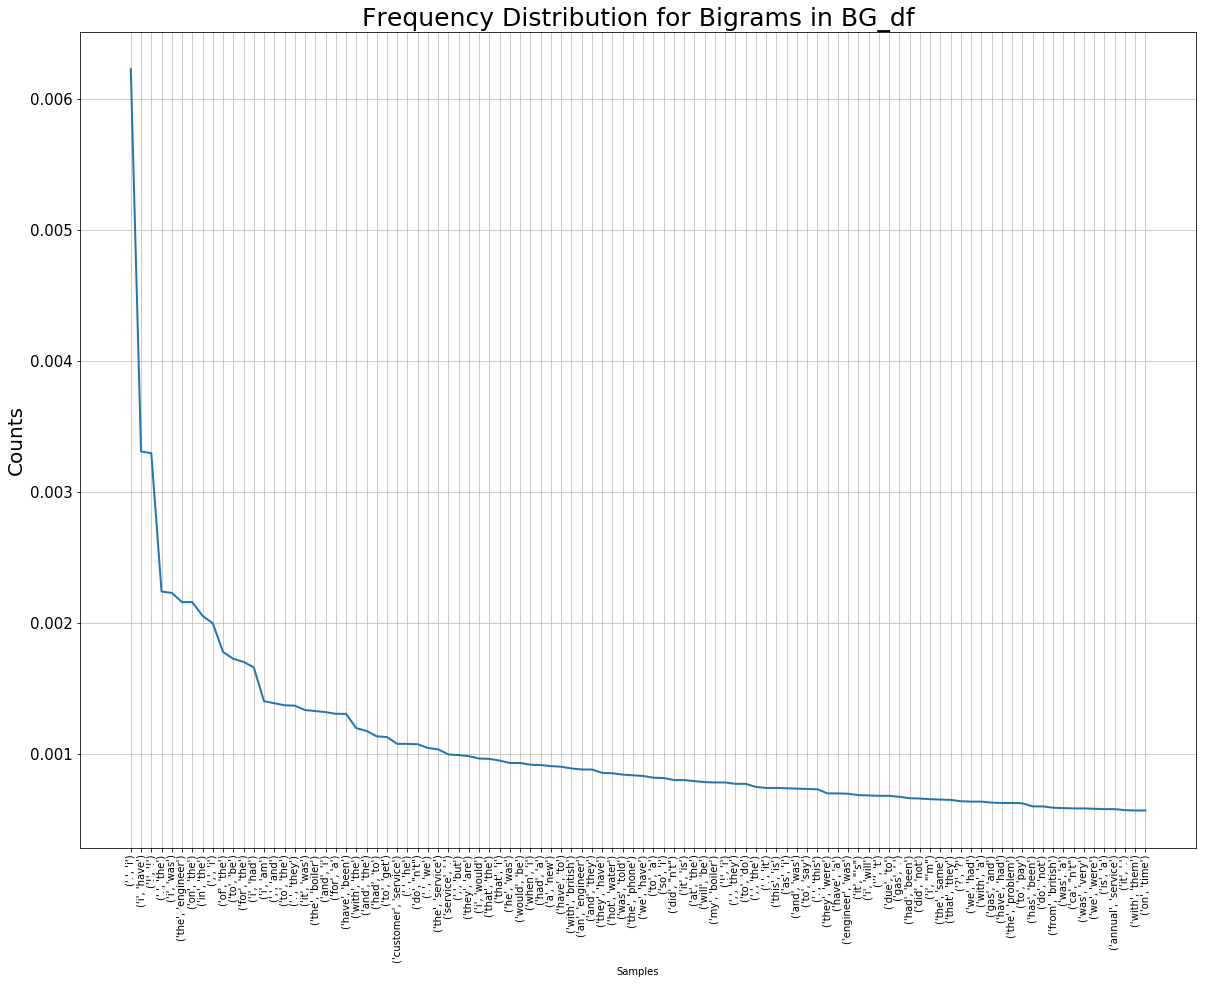

In [18]:
# commenting to speed loading in classification.ipynb
# # plot customisations
# fig = plt.figure(figsize=(20, 15))
# ax = fig.add_subplot(111)
# ax.grid()
# ax.set_xlabel('')
# ax.set_ylabel('Frequency', fontsize=20)
# ax.tick_params(axis='y', which='major', labelsize=15)
# ax.set_title("Frequency Distribution for Bigrams in BG_df", fontsize=25)

# # plot bigram frequency distribution to find the optimal value of n for BG_df
# tokens_BG = BG_df['tokens'].sum() # add all tokens
# bigram_BG = list(bigrams(tokens_BG)) # create all bigrams
# bigram_BG = FreqDist(bigram_BG)
# del bigram_BG[('british', 'gas')] # remove 'british gas' as it's an outlier and skews the plot

# # frequency of count of word over total words (normalisation)
# total_bigram_BG = bigram_BG.N()
# for bigram in bigram_BG:
#     bigram_BG[bigram] /= float(total_bigram_BG)

# bigram_BG.plot(100, cumulative=False)

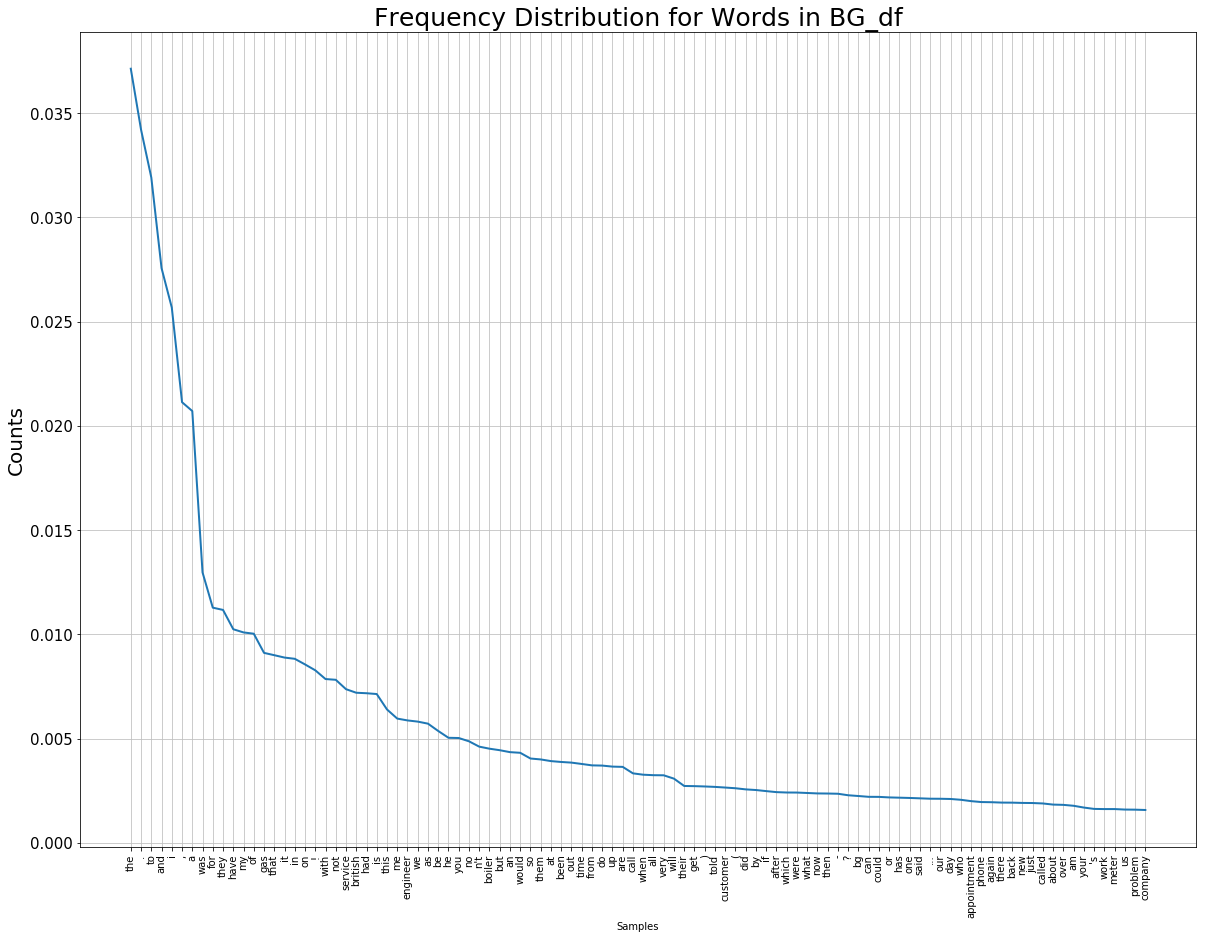

In [19]:
# commenting to speed loading in classification.ipynb
# # plot customisations
# fig = plt.figure(figsize=(20, 15))
# ax = fig.add_subplot(111)
# ax.grid()
# ax.set_xlabel('')
# ax.set_ylabel('Frequency', fontsize=20)
# ax.tick_params(axis='y', which='major', labelsize=15)
# ax.set_title("Frequency Distribution for Words in BG_df", fontsize=25)

# # plot words frequency distribution to find the optimal value of n for BG_df
# words_BG = BG_df['tokens'].sum()
# words_BG = FreqDist(words_BG)

# # frequency of count of word over total words (normalisation)
# total_words_BG = words_BG.N()
# for word in words_BG:
#     words_BG[word] /= float(total_words_BG)

# words_BG.plot(100, cumulative=False)

From the two plots, it seems that our corpus is top heavy where only around 30 words or bigrams are dominant. 

There might be alot of words within our corpus, but majority of them would yield only small information in classifying especially since our data set is top heavy. One technique that can be use in feature creation is feature selection where we use only the most significant words, words with high information gain values. This reduces the dimension of our data and would provide a better result. This is performed by using the chi-square test as the metric to find words with high semantic contents.

First, let's look at the total number of words in BG_df.

In [20]:
# total number of words in BG_df
word_BG = len(BG_df['tokens'].sum())
# print('BG: %d words, with an average of %d words per review.' % (word_BG, word_BG/3519))

BG: 386459 words, with an average of 109 words per review.


Next, we use the chi-square test to find n most significant words within our BG_df. We expect the optimal value of n to be 30 based on the plots above.

In [21]:
freq_dist = FreqDist()
cond_freq = ConditionalFreqDist()

# function to find most informative or significant words 
def informative_words(df, n):
    neg_tokens = df[df['sentiment'] == 'Positive']['tokens'].sum()
    pos_tokens = df[df['sentiment'] == 'Negative']['tokens'].sum()

    for word in neg_tokens:
        freq_dist[word] += 1
        cond_freq['Positive'][word] += 1

    for word in pos_tokens :
        freq_dist[word] += 1
        cond_freq['Negative'][word] += 1
    
    neg_words = cond_freq['Negative'].N()
    pos_words = cond_freq['Positive'].N()
    
    total_words = neg_words + pos_words
 
    words_scores = {}
 
    for word, freq in freq_dist.items():
        neg_score = BigramAssocMeasures.chi_sq(cond_freq['Negative'][word],
            (freq, neg_words), total_words)
        pos_score = BigramAssocMeasures.chi_sq(cond_freq['Positive'][word],
            (freq, pos_words), total_words)
        
        words_scores[word] = pos_score + neg_score

    informative = sorted(words_scores.items(), key=lambda x: x[1], reverse=True)[:n]
    inform_words = set([t for t, x in informative]) # change to set
    
    return inform_words

Our last step in the pre-processing is feature extraction for our classifier model. Our features would be unigrams or a combination of most significant unigrams and bigrams. The functions below are used to extract the features which in its base model is the availability of the word within the document.

In [22]:
# function to create only unigrams features
def unigram_features(words):
    return dict([(word, True) for word in words])

# function to create unigrams and bigrams features
def bigram_features(words, score_fn=BigramAssocMeasures.chi_sq, b=30):
    bigram_finder = BigramCollocationFinder.from_words(words)
    bigrams = bigram_finder.nbest(score_fn, b)
    return dict([(ngram, True) for ngram in itertools.chain(words, bigrams)])

In [23]:
# function to create unigrams features from most significant unigrams
def informative_word_features(words):
    return dict([(word, True) for word in words if word in inform_words])

# function to create unigrams and bigrams features from most significant unigrams and bigrams
def informative_word_bigram_features(words, score_fn=BigramAssocMeasures.chi_sq, b=30):
    bigram_finder = BigramCollocationFinder.from_words(words)
    bigrams = bigram_finder.nbest(score_fn, b)
    d = dict([(bigram, True) for bigram in bigrams])
    d.update(informative_word_features(words))
    return d

In [24]:
# function to create features based on df, feature function and polarity
def feature_extract(df, feature_function, polarity):
    reviews = df[df['sentiment'] == polarity]['tokens']
    
    features = []
    for f in reviews:
        try:
            features.append((feature_function(f), polarity))
        except:
            continue
    
    return features

In [25]:
# removing a bug where the repeating words caused an error in feature_extract
# token at BG_df[375] replaced from ['scammers', 'scammers', 'scammers'] to ['scammers']
BG_df.at[375, 'tokens'] = ['scammers']

Since the text normalisation part affects the final features, we create two different data frames depending on the text pre-processing techniques that have been applied for testing purposes. One data frame is stemmed while the other is lemmatised. 

In [26]:
# The list of functions are as follow:
# stops_removal() - removing stop words and punctuations
# stemming()      - stemming the words
# lemmatise()     - lemmatise the words

# Stemming BG_df
BG_stem = BG_df.copy() # copy original df to keep it intact
BG_stem = stops_removal(BG_stem)
BG_stem = stemming(BG_stem)

# lemmatising BG_df
BG_lemma = BG_df.copy() # copy original df to keep it intact
BG_lemma = stops_removal(BG_lemma)
BG_lemma = lemmatise(BG_lemma)

The difference between stemming and lemmatisation is shown below. The example is taken from the first review in the data set.

In [27]:
# stemmed tokens
# print(BG_stem['tokens'][0])

['hive', 'engin', 'fail', 'show', 'twice', 'taken', 'two', 'day', 'off', 'work', 'get', 'hive', 'instal', 'british', 'gas', 'employe', 'give', 'monkey', 'suppos', 'sharehold', 'suffer', 'engin', 'not', 'show', 'twice', 'decid', 'cancel', 'boiler', 'care', 'applianc', 'cover', 'well', 'cancel', 'hive', 'contract', 'sum', '£110', 'month', 'lost', 'give', 'money', 'someon', 'want', 'honest', 'guy', 'great', 'year', 'back', 'mediocr', 'best', 'hell', 'happen']


In [28]:
# lemmatised tokens
# print(BG_lemma['tokens'][0])

['hive', 'engineer', 'fail', 'show', 'twice', 'take', 'two', 'day', 'off', 'work', 'get', 'hive', 'installed', 'british', 'gas', 'employee', 'give', 'monkey', 'suppose', 'shareholder', 'suffer', 'engineer', 'not', 'show', 'twice', 'decide', 'cancel', 'boiler', 'care', 'appliance', 'cover', 'well', 'cancel', 'hive', 'contract', 'sum', '£110', 'month', 'lose', 'give', 'money', 'someone', 'want', 'honestly', 'guys', 'great', 'year', 'back', 'mediocre', 'best', 'hell', 'happen']


In [29]:
# print the data frames to be used in classifier.ipynb
BG_list = ['BG_stem', 'BG_lemma']

# naming all df for future use
BG_stem.name = 'BG_stem'
BG_lemma.name = 'BG_lemma'


print('There are 2 data frames to be used for classification:')
for df in BG_list:
    print(df)
        
print('\nThere are 4 feature extraction methods:')
print('unigram_features:                   all words')
print('bigram_features:                    all words and most significant bigrams')
print('informative_word_features:          most significant words only')
print('informative_word_bigram_features:   most significant words and bigrams')

There are 2 data frames to be used for classification:
BG_stem
BG_lemma

There are 4 feature extraction methods:
unigram_features:                   all words
bigram_features:                    all words and most significant bigrams
informative_word_features:          most significant words only
informative_word_bigram_features:   most significant words and bigrams


The features are then extracted from the data frames in classifier.ipynb and sentiment classification is performed then.